In [1]:
#import needed libraries in

import ee
import numpy as np
import pandas as pd

import geemap.eefolium as geemap
import folium
from folium import plugins

from earthshot import normalize as norm
from earthshot import water_viz as vis

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline

Loading BokehJS ...

In [2]:
ee.Initialize()

In [3]:
#Import training data in from GEE
training = ee.FeatureCollection('users/amgadellaboudy/training_coll')

In [4]:
#Convert from feature collection into Pandas Dataframe for analysis

selectors = ee.List(['slope', 'surface_runoff', 'surface_net_solar_radiation', 'total_precipitation', 'b0','temperature_2m','NDVI_pre', 'Beaver Dam', 'NDVI'])

training_df = pd.DataFrame(training.reduceColumns(reducer = ee.Reducer.toList().repeat(selectors.size()), selectors = selectors).get('list').getInfo()).transpose()

training_df = training_df.rename(columns = {0: 'Slope', 1: 'Runoff', 2: 'Solar Radiation', 3: 'Precip', 4: 'Soil', 5: 'Temp', 6: 'Pre_NDVI', 7: 'Beaver Dam', 8: 'NDVI' })

training_df.head()

,Slope,Runoff,Solar Radiation,Precip,Soil,Temp,Pre_NDVI,Beaver Dam,NDVI
0,3.850401,0.000049,1.746246e+07,0.001357,27.0,281.146955,0.285082,0.0,0.329306
1,5.232588,0.000049,1.746246e+07,0.001357,27.0,281.146955,0.296563,0.0,0.329599
2,5.938238,0.000049,1.746246e+07,0.001357,27.0,281.146955,0.320601,0.0,0.362412
3,10.360916,0.000045,1.773715e+07,0.000929,27.0,284.692148,0.143532,0.0,0.294328
4,9.582003,0.000045,1.773715e+07,0.000929,27.0,284.692148,0.062040,0.0,0.189787


In [5]:
#Start training data for XGBoost model

X = training_df.drop('NDVI', axis =1).values
y = training_df['NDVI'].values

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score
import xgboost
from xgboost import XGBRegressor

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [55]:
xgb_class = XGBRegressor(n_estimators = 100, learning_rate = 0.05, subsample = 0.4)

xgb_class.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.4,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [56]:
#Produce predictions, RMSE, and explained variance for comparison to GEE model

predictions = xgb_class.predict(X_test)
predictions_t = xgb_class.predict(X_train)

In [57]:
print('RMSE (training):', np.sqrt(mean_squared_error(y_train,predictions_t)))
print('RMSE (validation):', np.sqrt(mean_squared_error(y_test,predictions)))

RMSE (training): 0.042484486613492904
RMSE (validation): 0.04575224099103671


In [58]:
print('Explained variance (training):', explained_variance_score(y_train,predictions_t))
print('Explained variance (validation):', explained_variance_score(y_test,predictions))

Explained variance (training): 0.8947952700763946
Explained variance (validation): 0.8730485941261482


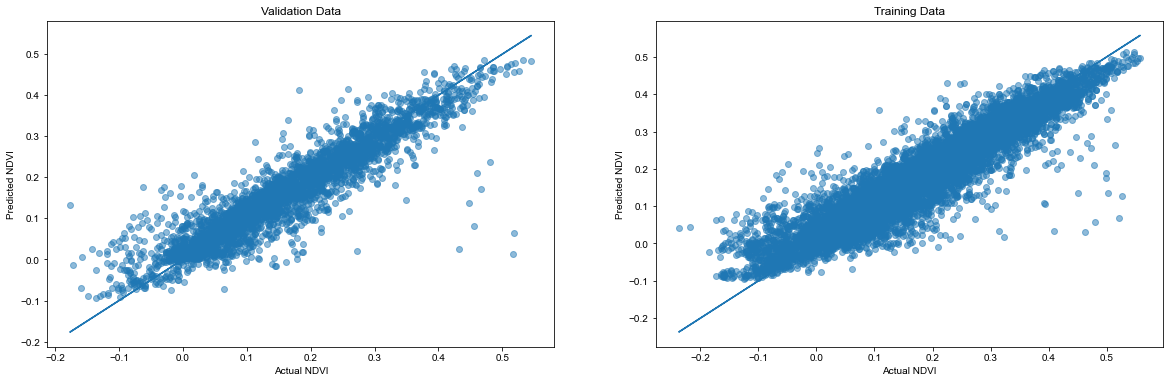

In [59]:
#Plot validation/ training data vs. predictions

fig, ax = plt.subplots(nrows = 1, ncols =2, figsize = (20,6))

font = {'family' : 'Arial',
        'size'   : 10}

plt.rc('font', **font)

scatter = ax[0].scatter(y_test, predictions, alpha = 0.5)
plot = ax[0].plot(y_test, y_test)
ax[0].set(title = 'Validation Data', xlabel = 'Actual NDVI', ylabel = 'Predicted NDVI')

plt.xlabel('Actual NDVI')
plt.ylabel('Predicted NDVI')

scatter_t = ax[1].scatter(y_train, predictions_t, alpha = 0.5)
plot_t = ax[1].plot(y_train, y_train)
ax[1].set(title = 'Training Data', xlabel = 'Actual NDVI', ylabel = 'Predicted NDVI')


plt.show()

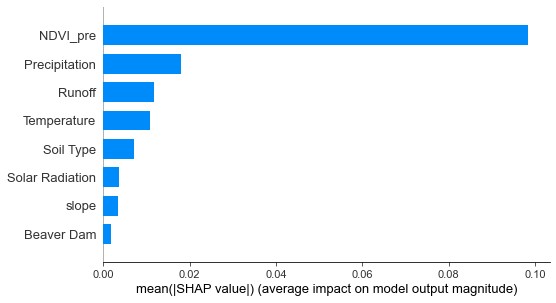

In [60]:
#Plot Shapley values to indicate importance of each feature in the model

import torch
import shap
shap.initjs()

features = ['slope', 'Runoff', 'Solar Radiation', 'Precipitation', 'Soil Type',
            'Temperature','NDVI_pre', 'Beaver Dam']

shap_values = shap.Explainer(xgb_class).shap_values(X_train)
shap.summary_plot(shap_values, X_train, feature_names = features, plot_type="bar")

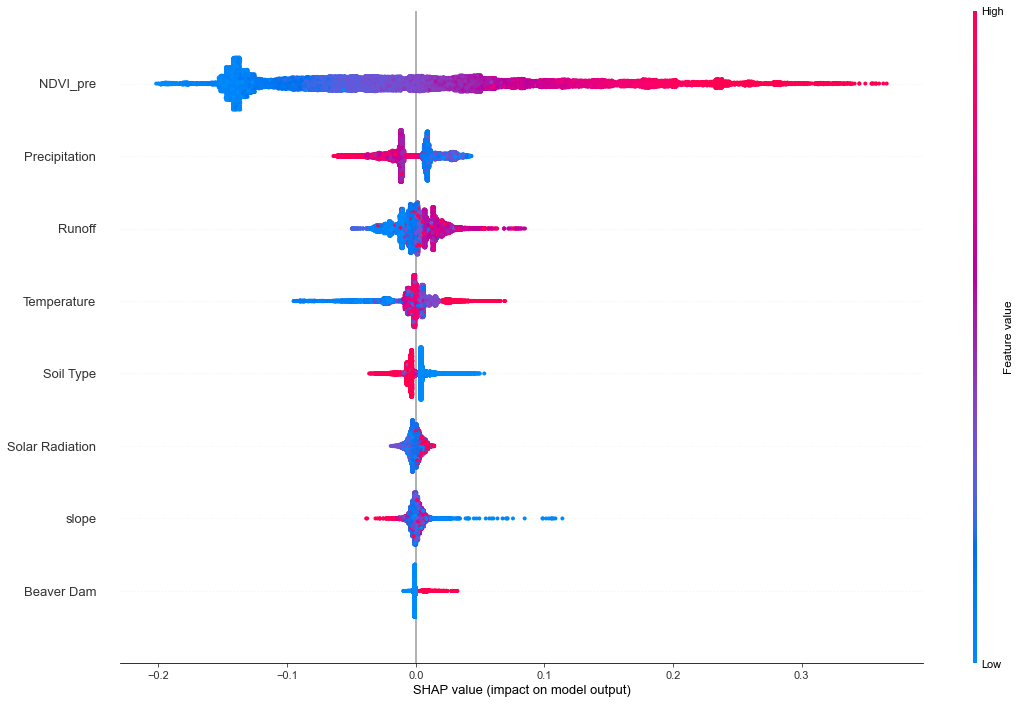

In [61]:
#Indicate how each feature is influencing the outcome

shap.summary_plot(shap_values, X_train, feature_names = features, plot_size = (18,12))